In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import wavelet_transform as wt
from create_graph import create_graph

In [38]:
shapefile = gpd.read_file("data/LAYER_DISTRITO/sp.shp")
adj_matrix = create_graph(shapefile)
signal_1 = np.load("data/time_series/furto_celular_district.npy")
signal_2 = np.load("data/time_series/roubo_celular_district.npy")
n_timestamps = signal_1.shape[1]

In [34]:
wav =  wt.WaveletTransform(
    adj_matrix,
    n_timestamps,
    graph_product="strong",
    n_filters=32,
    kernel="abspline",
    scaling_function=False,
    method="chebyshev",
    order_chebyshev=30,
)

In [39]:
coeffs_1 = wav.transform(signal_1)
coeffs_2 = wav.transform(signal_2)

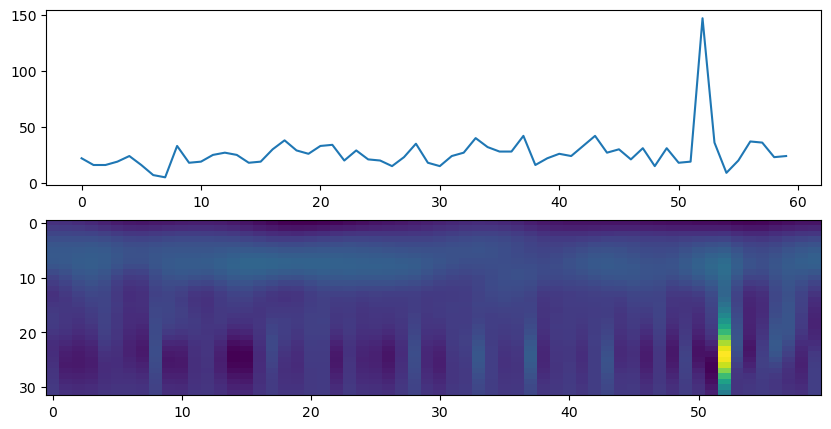

In [36]:
i = 0
fig = plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(signal_1[i])

plt.subplot(2, 1, 2)
plt.imshow(coeffs_1[i].T, aspect="auto", cmap="viridis")

plt.show()

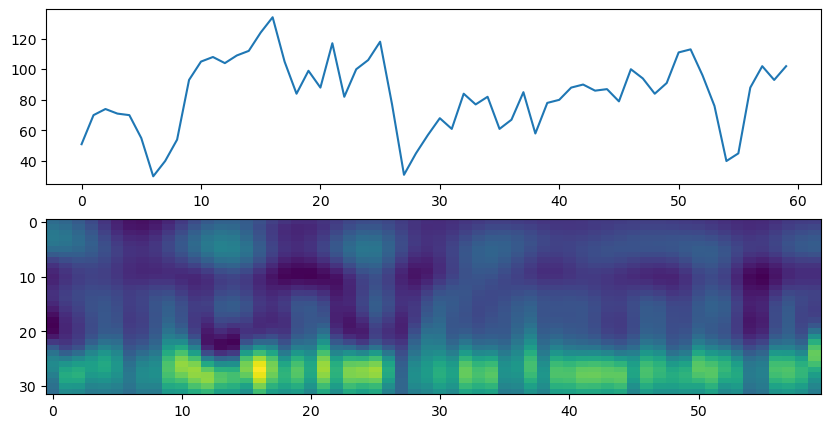

In [37]:
i = 10
fig = plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(signal_1[i])

plt.subplot(2, 1, 2)
plt.imshow(coeffs_1[i].T, aspect="auto", cmap="viridis")

plt.show()